In [1]:
import pandas as pd
import numpy as np
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DataProcessing

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def prepare_data_ae(original_data):
    distinct_activities = original_data['Type of economic activity'].unique()
    original_data['Consumption per meter (L/Day)'] = original_data['Consumption (L/Day)'] /original_data['Number of meters']
    columns_to_drop = ['Consumption (L/Day)', 'Number of meters']
    original_data = original_data.drop(columns=columns_to_drop)

    # Group the DataFrame by 'District', 'Use', and 'Type of economic activity'
    grouped_data = original_data.groupby(['Postcode', 'Use', 'Type of economic activity'])

    postcode_activity_dataframes = {}
    reshaped_data_list = []
    for (postcode, use, activity), data in grouped_data:
        key = f'{postcode}_{use}_{activity}'
        postcode, use, activity = key.split('_')

        postcode_activity_dataframes[key] = data.copy()
        #postcode_activity_dataframes[key]['Date'] = pd.to_datetime(postcode_activity_dataframes[key][['Year', 'Month', 'Day']])
        postcode_activity_dataframes[key] = postcode_activity_dataframes[key].sort_values(by='Date', ascending=True)

        label_encoder = LabelEncoder()

        df_encoded = postcode_activity_dataframes[key]

        df_encoded['Postcode'] = label_encoder.fit_transform(df_encoded['Postcode'])
        df_encoded['Use'] = label_encoder.fit_transform(df_encoded['Use'])
        df_encoded['Type of economic activity'] = label_encoder.fit_transform(df_encoded['Type of economic activity'])

        df_encoded.reset_index(inplace=True)
        df_encoded = df_encoded.groupby('Date').agg({
            'Postcode': 'first',
            'Use': 'first',
            'Type of economic activity':'first',
            'Consumption per meter (L/Day)': 'max',
            # 'Precipitaciones (mm)': 'mean',
            #
            'Date' : 'first',
            # 'T_max (C)': 'mean',
            # 'T_min (C)': 'mean',
            'spi_12': 'mean',
            'spi_9': 'mean',
            'scpdsi': 'mean'
        }).reset_index(drop=True)

        data = df_encoded.values
        postcode_activity_dataframes[key] = df_encoded
        if (data.shape[0]) == 1460 :
            reshaped_data_list.append(data)

    reshaped_data = np.stack(reshaped_data_list, axis=0)

    return reshaped_data, postcode_activity_dataframes

In [3]:
path = '/content/drive/MyDrive/Project Management/AB Data/Datasets limpios/Datasets_Barcelona/abdataset1_rest_seq_v2.csv'
original_data = pd.read_csv(path)
original_data['Type of economic activity'] = original_data['Type of economic activity']
tensor_data, dataframes = prepare_data_ae(original_data)

In [4]:
print(tensor_data.shape)
print(tensor_data[0][2])

(1251, 1460, 8)
[0 0 0 1223.0 '2019-01-03' 1.59 1.2 2.59]


In [5]:
data_without_timestamp = np.delete(tensor_data, 4, axis=-1)
tensor_data = data_without_timestamp.astype(float)
del data_without_timestamp

In [6]:
# Define the sequence length (time window)
seq_length = 30  # You can adjust this based on your requirement

# Reshape the data into sequences of specified time window
def create_sequences(data, seq_length):
    sequences = []
    num_batches, num_timesteps, num_features = data.shape

    for i in range(num_batches):
        for j in range(0, num_timesteps - seq_length + 1):
            sequence = data[i, j:j+seq_length, :]
            sequences.append(sequence)

    return np.array(sequences)

# Prepare sequences for input to the model
sequences = create_sequences(tensor_data, seq_length)

# Print the shape of the prepared sequences
print("Shape of prepared sequences:", sequences.shape)

Shape of prepared sequences: (1790181, 30, 7)


In [7]:
# Function to create sequences from the 3D tensor
#def to_sequences(data, seq_size=1):
 #   x_values = []
 #   y_values = []
#
#    for i in range(len(data) - seq_size):
 #       x_values.append(data[i:(i + seq_size)])
 #       y_values.append(data[i + seq_size])

  #  return np.array(x_values), np.array(y_values)

# Set the sequence size
#seq_size = 30  # Number of time steps to look back

# Create sequences for LSTM model
#x_sequences, y_sequences = [], []
#for series in tensor_data:
  #  x, y = to_sequences(series, seq_size)
  #  x_sequences.append(x)
  #  y_sequences.append(y)

# Convert the lists to numpy arrays
#trainX = np.array(x_sequences)
#trainY = np.array(y_sequences)

#print(trainX.shape)
#print(trainY.shape)

# KERAS VAE-LSTM

In [ ]:
from keras.layers import Input
from keras.models import Model

# Define the input shape based on the number of time series, time steps, and features
input_shape = (trainX.shape[1], trainX.shape[2], trainX.shape[3])  # (num_sequences, seq_size, num_features)

# Define the encoder
encoder_inputs = Input(shape=input_shape)
encoder_lstm1 = LSTM(128, return_sequences=False)(encoder_inputs)
encoder_dropout1 = Dropout(rate=0.2)(encoder_lstm1)

# Bottleneck layer
encoded = RepeatVector(input_shape[0])(encoder_dropout1)

# Define the decoder
decoder_lstm1 = LSTM(128, return_sequences=True)(encoded)
decoder_dropout1 = Dropout(rate=0.2)(decoder_lstm1)
decoder_outputs = TimeDistributed(Dense(input_shape[1]))(decoder_dropout1)

# Create the autoencoder model
autoencoder = Model(inputs=encoder_inputs, outputs=decoder_outputs)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

# Train the model
history = autoencoder.fit(trainX, trainY, epochs=10, batch_size=1, validation_split=0.1, verbose=1)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

45/45 [==============================] - 0s 4ms/step


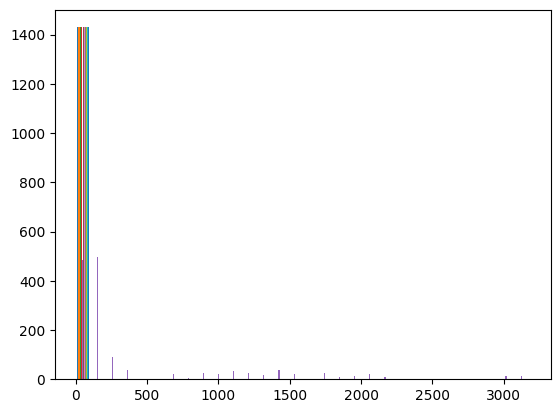

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

In [ ]:
tensor_data.shape

(6, 1460, 11)

# LSTM-VAE SIMPLE

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the LSTM-VAE model
class LSTMVAE(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMVAE, self).__init__()
        self.encoder_lstm = nn.LSTM(input_size, hidden_size)
        self.decoder_lstm = nn.LSTM(hidden_size, input_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        # Encoder
        _, (encoder_hidden, encoder_cell) = self.encoder_lstm(x)

        # Bottleneck layer
        bottleneck = encoder_hidden.view(-1, 1, self.hidden_size).repeat(x.size(0), 1, 1)

        # Decoder
        output, _ = self.decoder_lstm(bottleneck)
        return output

# Define the input size (number of features) and hidden size
input_size = sequences.shape[2]  # number of features in each time step
hidden_size = 128

# Initialize the model
lstm_vae = LSTMVAE(input_size, hidden_size)

# Define the loss function (Mean Absolute Error)
criterion = nn.L1Loss()

# Define the optimizer
optimizer = torch.optim.Adam(lstm_vae.parameters(), lr=0.001)

# Convert sequences to PyTorch tensor
sequences_tensor = torch.tensor(sequences, dtype=torch.float32)

# Training the model
num_epochs = 10
history = []
for epoch in range(num_epochs):
    lstm_vae.train()
    total_loss = 0

    # Iterate over the sequences in each epoch
    for i in range(sequences.shape[0]):
        # Extract the current sequence
        input_sequence = sequences_tensor[i].unsqueeze(0)  # add batch dimension
        print(input_sequence)
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output_sequence = lstm_vae(input_sequence)

        # Calculate the loss
        loss = criterion(output_sequence, input_sequence)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for this epoch
        total_loss += loss.item()

    # Calculate the average loss for this epoch
    average_loss = total_loss / sequences.shape[0]
    history.append(average_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    if (epoch + 1) % 5 == 0:  # Visualize every 5 epochs (you can adjust this as needed)
        with torch.no_grad():
            reconstructed_sequence = lstm_vae(input_sequence)

            # Convert tensors back to numpy arrays for plotting
            input_sequence_np = input_sequence.squeeze().numpy()
            reconstructed_sequence_np = reconstructed_sequence.squeeze().numpy()

            # Plot input and reconstructed sequences
            plt.figure(figsize=(10, 5))
            plt.plot(input_sequence_np, label='Input Sequence')
            plt.plot(reconstructed_sequence_np, label='Reconstructed Sequence')
            plt.xlabel('Time Step')
            plt.ylabel('Feature Value')
            plt.title('Input Sequence vs. Reconstructed Sequence')
            plt.legend()
            plt.show()

# Plotting the training loss
plt.plot(range(1, num_epochs+1), history, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# USAD

In [8]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [9]:
!git clone https://github.com/manigalati/usad

fatal: destination path 'usad' already exists and is not an empty directory.


In [10]:
%cd usad

/content/usad


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [12]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla T4 (UUID: GPU-45c86449-8791-8b9f-fe47-ddc101987030)


In [13]:
window_size=12

In [14]:
#windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]

sequences_train = sequences[:int(np.floor(.8 *  sequences.shape[0]))]
sequences_val = sequences[int(np.floor(.8 *  sequences.shape[0])):int(np.floor(sequences.shape[0]))]


In [15]:
import torch.utils.data as data_utils

BATCH_SIZE =  1
N_EPOCHS = 1
hidden_size = 100

w_size=sequences.shape[1]*sequences.shape[2]
z_size=sequences.shape[1]*hidden_size

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(sequences).float().view(([sequences.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(sequences_val).float().view(([sequences_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

In [ ]:
plot_history(history)

In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

# Testing (hace falta ver como son los outputs y tal)

In [ ]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

In [ ]:
results=testing(model,val_loader)

In [ ]:
results.shape

In [ ]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

# MTGFLOW

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import math
import copy


# --------------------
# Model layers and helpers
# --------------------

def create_masks(input_size, hidden_size, n_hidden, input_order='sequential', input_degrees=None):
    # MADE paper sec 4:
    # degrees of connections between layers -- ensure at most in_degree - 1 connections
    degrees = []

    # set input degrees to what is provided in args (the flipped order of the previous layer in a stack of mades);
    # else init input degrees based on strategy in input_order (sequential or random)
    if input_size>1:
        if input_order == 'sequential':
            degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
            for _ in range(n_hidden + 1):
                degrees += [torch.arange(hidden_size) % (input_size - 1)]
            degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]

        elif input_order == 'random':
            degrees += [torch.randperm(input_size)] if input_degrees is None else [input_degrees]
            for _ in range(n_hidden + 1):
                min_prev_degree = min(degrees[-1].min().item(), input_size - 1)
                degrees += [torch.randint(min_prev_degree, input_size, (hidden_size,))]
            min_prev_degree = min(degrees[-1].min().item(), input_size - 1)
            degrees += [torch.randint(min_prev_degree, input_size, (input_size,)) - 1] if input_degrees is None else [input_degrees - 1]
    else:
        degrees += [torch.zeros([1]).long()]
        for _ in range(n_hidden+1):
            degrees += [torch.zeros([hidden_size]).long()]
        degrees += [torch.zeros([input_size]).long()]
    # construct masks
    masks = []
    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [(d1.unsqueeze(-1) >= d0.unsqueeze(0)).float()]

    return masks, degrees[0]

#%%

def create_masks_pmu(input_size, hidden_size, n_hidden, input_order='sequential', input_degrees=None):
    # MADE paper sec 4:
    # degrees of connections between layers -- ensure at most in_degree - 1 connections
    degrees = []

    # set input degrees to what is provided in args (the flipped order of the previous layer in a stack of mades);
    # else init input degrees based on strategy in input_order (sequential or random)
    if input_order == 'sequential':
        degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
        for _ in range(n_hidden + 1):
            degrees += [torch.arange(hidden_size) % (input_size - 1)]
        degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]

    # construct masks
    masks = []
    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [(d1.unsqueeze(-1) >= d0.unsqueeze(0)).float()]
    masks[0] = masks[0].repeat_interleave(3, dim=1)
    masks[-1] = masks[-1].repeat_interleave(3, dim=0)

    return masks, degrees[0]
#%%
class MaskedLinear(nn.Linear):
    """ MADE building block layer """
    def __init__(self, input_size, n_outputs, mask, cond_label_size=None):
        super().__init__(input_size, n_outputs)

        self.register_buffer('mask', mask)

        self.cond_label_size = cond_label_size
        if cond_label_size is not None:
            self.cond_weight = nn.Parameter(torch.rand(n_outputs, cond_label_size) / math.sqrt(cond_label_size))

    def forward(self, x, y=None):
        out = F.linear(x, self.weight * self.mask, self.bias)
        if y is not None:
            out = out + F.linear(y, self.cond_weight)
        return out

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        ) + (self.cond_label_size != None) * ', cond_features={}'.format(self.cond_label_size)


class LinearMaskedCoupling(nn.Module):
    """ Modified RealNVP Coupling Layers per the MAF paper """
    def __init__(self, input_size, hidden_size, n_hidden, mask, cond_label_size=None):
        super().__init__()

        self.register_buffer('mask', mask)

        # scale function
        s_net = [nn.Linear(input_size + (cond_label_size if cond_label_size is not None else 0), hidden_size)]
        for _ in range(n_hidden):
            s_net += [nn.Tanh(), nn.Linear(hidden_size, hidden_size)]
        s_net += [nn.Tanh(), nn.Linear(hidden_size, input_size)]
        self.s_net = nn.Sequential(*s_net)

        # translation function
        self.t_net = copy.deepcopy(self.s_net)
        # replace Tanh with ReLU's per MAF paper
        for i in range(len(self.t_net)):
            if not isinstance(self.t_net[i], nn.Linear): self.t_net[i] = nn.ReLU()

    def forward(self, x, y=None):
        # apply mask
        mx = x * self.mask

        # run through model
        s = self.s_net(mx if y is None else torch.cat([y, mx], dim=1))
        t = self.t_net(mx if y is None else torch.cat([y, mx], dim=1))
        u = mx + (1 - self.mask) * (x - t) * torch.exp(-s)  # cf RealNVP eq 8 where u corresponds to x (here we're modeling u)

        log_abs_det_jacobian = - (1 - self.mask) * s  # log det du/dx; cf RealNVP 8 and 6; note, sum over input_size done at model log_prob

        return u, log_abs_det_jacobian

    def inverse(self, u, y=None):
        # apply mask
        mu = u * self.mask

        # run through model
        s = self.s_net(mu if y is None else torch.cat([y, mu], dim=1))
        t = self.t_net(mu if y is None else torch.cat([y, mu], dim=1))
        x = mu + (1 - self.mask) * (u * s.exp() + t)  # cf RealNVP eq 7

        log_abs_det_jacobian = (1 - self.mask) * s  # log det dx/du

        return x, log_abs_det_jacobian


class BatchNorm(nn.Module):
    """ RealNVP BatchNorm layer """
    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps

        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))

        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))

    def forward(self, x, cond_y=None):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0) # note MAF paper uses biased variance estimate; ie x.var(0, unbiased=False)

            # update running mean
            self.running_mean.mul_(self.momentum).add_(self.batch_mean.data * (1 - self.momentum))
            self.running_var.mul_(self.momentum).add_(self.batch_var.data * (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        # compute normalized input (cf original batch norm paper algo 1)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta

        # compute log_abs_det_jacobian (cf RealNVP paper)
        log_abs_det_jacobian = self.log_gamma - 0.5 * torch.log(var + self.eps)
#        print('in sum log var {:6.3f} ; out sum log var {:6.3f}; sum log det {:8.3f}; mean log_gamma {:5.3f}; mean beta {:5.3f}'.format(
#            (var + self.eps).log().sum().data.numpy(), y.var(0).log().sum().data.numpy(), log_abs_det_jacobian.mean(0).item(), self.log_gamma.mean(), self.beta.mean()))
        return y, log_abs_det_jacobian.expand_as(x)

    def inverse(self, y, cond_y=None):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (y - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_abs_det_jacobian = 0.5 * torch.log(var + self.eps) - self.log_gamma

        return x, log_abs_det_jacobian.expand_as(x)


class FlowSequential(nn.Sequential):
    """ Container for layers of a normalizing flow """
    def forward(self, x, y):
        sum_log_abs_det_jacobians = 0
        for module in self:
            x, log_abs_det_jacobian = module(x, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return x, sum_log_abs_det_jacobians

    def inverse(self, u, y):
        sum_log_abs_det_jacobians = 0
        for module in reversed(self):
            u, log_abs_det_jacobian = module.inverse(u, y)
            sum_log_abs_det_jacobians = sum_log_abs_det_jacobians + log_abs_det_jacobian
        return u, sum_log_abs_det_jacobians

# --------------------
# Models
# --------------------

class MADE(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', input_degrees=None):
        """
        Args:
            input_size -- scalar; dim of inputs
            hidden_size -- scalar; dim of hidden layers
            n_hidden -- scalar; number of hidden layers
            activation -- str; activation function to use
            input_order -- str or tensor; variable order for creating the autoregressive masks (sequential|random)
                            or the order flipped from the previous layer in a stack of mades
            conditional -- bool; whether model is conditional
        """
        super().__init__()
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # create masks
        masks, self.input_degrees = create_masks(input_size, hidden_size, n_hidden, input_order, input_degrees)

        # setup activation
        if activation == 'relu':
            activation_fn = nn.ReLU()
        elif activation == 'tanh':
            activation_fn = nn.Tanh()
        else:
            raise ValueError('Check activation function.')

        # construct model
        self.net_input = MaskedLinear(input_size, hidden_size, masks[0], cond_label_size)
        self.net = []
        for m in masks[1:-1]:
            self.net += [activation_fn, MaskedLinear(hidden_size, hidden_size, m)]
        self.net += [activation_fn, MaskedLinear(hidden_size, 2 * input_size, masks[-1].repeat(2,1))]
        self.net = nn.Sequential(*self.net)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        # MAF eq 4 -- return mean and log std
        m, loga = self.net(self.net_input(x, y)).chunk(chunks=2, dim=1)
        u = (x - m) * torch.exp(-loga)
        # MAF eq 5
        log_abs_det_jacobian = - loga
        return u, log_abs_det_jacobian

    def inverse(self, u, y=None, sum_log_abs_det_jacobians=None):
        # MAF eq 3
        D = u.shape[1]
        x = torch.zeros_like(u)
        # run through reverse model
        for i in self.input_degrees:
            m, loga = self.net(self.net_input(x, y)).chunk(chunks=2, dim=1)
            x[:,i] = u[:,i] * torch.exp(loga[:,i]) + m[:,i]
        log_abs_det_jacobian = loga
        return x, log_abs_det_jacobian

    def log_prob(self, x, y=None):
        u, log_abs_det_jacobian = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + log_abs_det_jacobian, dim=1)


class MADE_Full(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', input_degrees=None):
        """
        Args:
            input_size -- scalar; dim of inputs
            hidden_size -- scalar; dim of hidden layers
            n_hidden -- scalar; number of hidden layers
            activation -- str; activation function to use
            input_order -- str or tensor; variable order for creating the autoregressive masks (sequential|random)
                            or the order flipped from the previous layer in a stack of mades
            conditional -- bool; whether model is conditional
        """
        super().__init__()
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # create masks
        masks, self.input_degrees = create_masks_pmu(int(input_size/3), hidden_size, n_hidden, input_order, input_degrees)

        # setup activation
        if activation == 'relu':
            activation_fn = nn.ReLU()
        elif activation == 'tanh':
            activation_fn = nn.Tanh()
        else:
            raise ValueError('Check activation function.')

        # construct model
        self.net_input = MaskedLinear(input_size, hidden_size, masks[0], cond_label_size)
        self.net = []
        for m in masks[1:-1]:
            self.net += [activation_fn, MaskedLinear(hidden_size, hidden_size, m)]
        self.net += [activation_fn, MaskedLinear(hidden_size, 2 * input_size, masks[-1].repeat(2,1))]
        self.net = nn.Sequential(*self.net)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        # MAF eq 4 -- return mean and log std
        m, loga = self.net(self.net_input(x, y)).chunk(chunks=2, dim=1)
        u = (x - m) * torch.exp(-loga)
        # MAF eq 5
        log_abs_det_jacobian = - loga
        return u, log_abs_det_jacobian

    def log_prob(self, x, y=None):
        u, log_abs_det_jacobian = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + log_abs_det_jacobian, dim=1)

import numpy as np
class MAF(nn.Module):
    def __init__(self, n_blocks, n_sensor, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', batch_norm=True, mode = 'rand'):
        super().__init__()
        # base distribution for calculation of log prob under the model
        if mode == 'zero':
            self.register_buffer('base_dist_mean', torch.zeros(n_sensor, 1))
            self.register_buffer('base_dist_var', torch.ones(n_sensor, 1))
        elif mode == 'rand':
            self.register_buffer('base_dist_mean', torch.randn(n_sensor, 1))
            self.register_buffer('base_dist_var', torch.ones(n_sensor, 1))

        else:
            raise AttributeError('no choice')
        # construct model
        modules = []
        self.input_size = input_size
        self.input_degrees = None
        for i in range(n_blocks):
            modules += [MADE(input_size, hidden_size, n_hidden, cond_label_size, activation, input_order, self.input_degrees)]
            self.input_degrees = modules[-1].input_degrees.flip(0)
            modules += batch_norm * [BatchNorm(input_size)]

        self.net = FlowSequential(*modules)


    def base_dist(self, z, k, window_size):
        # C = z.shape[-1]
        # C = 51
        N =  z.shape[0]//k//window_size
        logp = - 0.5*(z-self.base_dist_mean.repeat_interleave(window_size, 0).repeat(N,1))**2

        return logp

    def forward(self, x, y=None):
        return self.net(x, y)

    def inverse(self, u, y=None):
        return self.net.inverse(u, y)

    def log_prob(self, x, k, window_size, y=None):
        # print('shape', self.base_dist_mean.shape)
        u, sum_log_abs_det_jacobians = self.forward(x, y)
        C = u.shape[1]
        return torch.sum(self.base_dist(u, k, window_size) + sum_log_abs_det_jacobians, dim=1)+ C * _GCONST_ #,u




class MAF_Full(nn.Module):
    def __init__(self, n_blocks, n_sensor, input_size, hidden_size, n_hidden, cond_label_size=None, activation='relu', input_order='sequential', batch_norm=True):
        super().__init__()
        # base distribution for calculation of log prob under the model
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))

        # construct model
        modules = []
        self.input_degrees = None
        for i in range(n_blocks):
            modules += [MADE_Full(input_size, hidden_size, n_hidden, cond_label_size, activation, input_order, self.input_degrees)]
            self.input_degrees = modules[-1].input_degrees.flip(0)
            modules += batch_norm * [BatchNorm(input_size)]

        self.net = FlowSequential(*modules)

    @property
    def base_dist(self):
        return D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x, y=None):
        return self.net(x, y)

    def inverse(self, u, y=None):
        return self.net.inverse(u, y)

    def log_prob(self, x, y=None):
        u, sum_log_abs_det_jacobians = self.forward(x, y)
        return torch.sum(self.base_dist.log_prob(u) + sum_log_abs_det_jacobians, dim=1)

_GCONST_ = -0.9189385332046727 # ln(sqrt(2*pi))

In [ ]:
from cgitb import reset
from turtle import forward, shape
from numpy import percentile
import torch.nn as nn
import torch.nn.functional as F
import torch

def interpolate(tensor, index, target_size, mode = 'nearest', dim = 0):
    print(tensor.shape)
    source_length = tensor.shape[dim]
    if source_length > target_size:
        raise AttributeError('no need to interpolate')
    if dim == -1:
        new_tensor = torch.zeros((*tensor.shape[:-1], target_size),dtype=tensor.dtype, device=tensor.device)
    if dim == 0:
        new_tensor = torch.zeros((target_size, *tensor.shape[1:], ),dtype=tensor.dtype, device=tensor.device)
    scale = target_size // source_length
    reset = target_size % source_length
    # if mode == 'nearest':
    new_index = index
    new_tensor[new_index, :] = tensor
    new_tensor[:new_index[0], :] = tensor[0,:].unsqueeze(0)
    for i in range(source_length-1):
        new_tensor[new_index[i]:new_index[i+1] , :] = tensor[i,:].unsqueeze(0)
    new_tensor[new_index[i+1] :,:] = tensor[i+1,:].unsqueeze(0)
    return new_tensor

class GNN(nn.Module):
    """
    The GNN module applied in GANF
    """
    def __init__(self, input_size, hidden_size):

        super(GNN, self).__init__()
        self.lin_n = nn.Linear(input_size, hidden_size)
        self.lin_r = nn.Linear(input_size, hidden_size, bias=False)
        self.lin_2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, h, A):
        ## A: K X K
        ## H: N X K  X L X D
        # print(h.shape, A.shape)
        # h_n = self.lin_n(torch.einsum('nkld,kj->njld',h,A))
        # h_n = self.lin_n(torch.einsum('nkld,kj->njld',h,A))
        # print(h.shape, A.shape)
        h_n = self.lin_n(torch.einsum('nkld,nkj->njld',h,A))
        h_r = self.lin_r(h[:,:,:-1])
        h_n[:,:,1:] += h_r
        h = self.lin_2(F.relu(h_n))

        return h

import math
import torch.nn as nn
import matplotlib.pyplot as plt
def plot_attention(data, i, X_label=None, Y_label=None):
  '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
  '''
  fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
  heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
  fig.colorbar(heatmap)
  # Set axis labels
  if X_label != None and Y_label != None:
    X_label = [x_label for x_label in X_label]
    Y_label = [y_label for y_label in Y_label]

    xticks = range(0,len(X_label))
    ax.set_xticks(xticks, minor=False) # major ticks
    ax.set_xticklabels(X_label, minor = False, rotation=45)   # labels should be 'unicode'

    yticks = range(0,len(Y_label))
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(Y_label[::-1], minor = False)   # labels should be 'unicode'

    ax.grid(True)
    plt.show()
    plt.savefig('graph/attention{:04d}.jpg'.format(i))



class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self, c):
        super(ScaleDotProductAttention, self).__init__()
        self.w_q = nn.Linear(c, c)
        self.w_k = nn.Linear(c, c)
        self.w_v = nn.Linear(c, c)
        self.softmax = nn.Softmax(dim = 1)
        self.dropout = nn.Dropout(0.2)
        # swat_0.2
    def forward(self, x,mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        shape = x.shape
        x_shape = x.reshape((shape[0],shape[1], -1))
        batch_size, length, c = x_shape.size()
        q = self.w_q(x_shape)
        k = self.w_k(x_shape)
        k_t = k.view(batch_size, c, length)  # transpose
        score = (q @ k_t) / math.sqrt(c)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -1e9)

        # 3. pass them softmax to make [0, 1] range
        score = self.dropout(self.softmax(score))



        return score, k


class MTGFLOW(nn.Module):

    def __init__ (self, n_blocks, input_size, hidden_size, n_hidden, window_size, n_sensor, dropout = 0.1, model="MAF", batch_norm=True):
        super(MTGFLOW, self).__init__()

        self.rnn = nn.LSTM(input_size=input_size,hidden_size=hidden_size,batch_first=True, dropout=dropout)
        self.gcn = GNN(input_size=hidden_size, hidden_size=hidden_size)
        if model=="MAF":
            # self.nf = MAF(n_blocks, n_sensor, input_size, hidden_size, n_hidden, cond_label_size=hidden_size, batch_norm=batch_norm,activation='tanh', mode = 'zero')
            self.nf = MAF(n_blocks, n_sensor, input_size, hidden_size, n_hidden, cond_label_size=hidden_size, batch_norm=batch_norm,activation='tanh')

        self.attention = ScaleDotProductAttention(window_size*input_size)
    def forward(self, x, ):

        return self.test(x, ).mean()

    def test(self, x, ):
        # x: N X K X L X D
        full_shape = x.shape
        graph,_ = self.attention(x)
        self.graph = graph
        # reshape: N*K, L, D
        x = x.reshape((x.shape[0]*x.shape[1], x.shape[2], x.shape[3]))
        h,_ = self.rnn(x)

        # resahpe: N, K, L, H
        h = h.reshape((full_shape[0], full_shape[1], h.shape[1], h.shape[2]))
        h = self.gcn(h, graph)

        # reshappe N*K*L,H
        h = h.reshape((-1,h.shape[3]))
        x = x.reshape((-1,full_shape[3]))
        log_prob = self.nf.log_prob(x, full_shape[1], full_shape[2], h).reshape([full_shape[0],-1])#
        log_prob = log_prob.mean(dim=1)

        return log_prob

    def get_graph(self):
        return self.graph

    def locate(self, x, ):
        # x: N X K X L X D
        full_shape = x.shape

        graph, _ = self.attention(x)
        # reshape: N*K, L, D
        self.graph = graph
        x = x.reshape((x.shape[0]*x.shape[1], x.shape[2], x.shape[3]))
        h,_ = self.rnn(x)

        # resahpe: N, K, L, H
        h = h.reshape((full_shape[0], full_shape[1], h.shape[1], h.shape[2]))
        h = self.gcn(h, graph)

        # reshappe N*K*L,H
        h = h.reshape((-1,h.shape[3]))
        x = x.reshape((-1,full_shape[3]))
        a = self.nf.log_prob(x, full_shape[1], full_shape[2], h)
        log_prob, z = a[0].reshape([full_shape[0],full_shape[1],-1]), a[1].reshape([full_shape[0],full_shape[1],-1])



        return log_prob.mean(dim=2), z.reshape((full_shape[0]* full_shape[1],-1))


class test(nn.Module):
    def __init__ (self, n_blocks, input_size, hidden_size, n_hidden, window_size, n_sensor, dropout = 0.1, model="MAF", batch_norm=True):
        super(test, self).__init__()

        if model=="MAF":
            self.nf = MAF(n_blocks, n_sensor, input_size, hidden_size, n_hidden, batch_norm=batch_norm,activation='tanh', mode='zero')
        self.attention = ScaleDotProductAttention(window_size*input_size)
    def forward(self, x, ):
        return self.test(x, ).mean()
    def test(self, x):
        x = x.unsqueeze(2).unsqueeze(3)
        full_shape = x.shape
        x = x.reshape((full_shape[0]*full_shape[1], full_shape[2], full_shape[3]))
        x = x.reshape((-1,full_shape[3]))
        log_prob = self.nf.log_prob(x, full_shape[1], full_shape[2]).reshape([full_shape[0],full_shape[1],-1])#*full_shape[1]*full_shape[2]
        log_prob = log_prob.mean(dim=1)
        return log_prob

    def locate(self, x, ):
        # x: N X K X L X D
        x = x.unsqueeze(2).unsqueeze(3)
        full_shape = x.shape

        x = x.reshape((x.shape[0]*x.shape[1], x.shape[2], x.shape[3]))

        # reshappe N*K*L,H
        x = x.reshape((-1,full_shape[3]))
        a = self.nf.log_prob(x, full_shape[1], full_shape[2])#*full_shape[1]*full_shape[2]
        log_prob, z = a[0].reshape([full_shape[0],full_shape[1],-1]), a[1].reshape([full_shape[0],full_shape[1],-1])


        return log_prob.mean(dim=2), z.reshape((full_shape[0]* full_shape[1],-1))

In [ ]:
import os
import argparse
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve

parser = argparse.ArgumentParser()

parser.add_argument('--data_dir', type=str,
                    default='Data/input/SWaT_Dataset_Attack_v0.csv', help='Location of datasets.')
parser.add_argument('--output_dir', type=str,
                    default='./checkpoint/')
parser.add_argument('--name',default='SWaT', help='the name of dataset')

parser.add_argument('--graph', type=str, default='None')
parser.add_argument('--model', type=str, default='MAF')


parser.add_argument('--n_blocks', type=int, default=1, help='Number of blocks to stack in a model (MADE in MAF; Coupling+BN in RealNVP).')
parser.add_argument('--n_components', type=int, default=1, help='Number of Gaussian clusters for mixture of gaussians models.')
parser.add_argument('--hidden_size', type=int, default=32, help='Hidden layer size for MADE (and each MADE block in an MAF).')
parser.add_argument('--n_hidden', type=int, default=1, help='Number of hidden layers in each MADE.')
parser.add_argument('--input_size', type=int, default=1)
parser.add_argument('--batch_norm', type=bool, default=False)
parser.add_argument('--train_split', type=float, default=1)
parser.add_argument('--stride_size', type=int, default=10)

parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--weight_decay', type=float, default=5e-4)
parser.add_argument('--window_size', type=int, default=60)
parser.add_argument('--lr', type=float, default=2e-3, help='Learning rate.')



args = parser.parse_known_args()[0]
args.cuda = torch.cuda.is_available()
device = torch.device("cuda" if args.cuda else "cpu")


#for seed in range(15,20):
args.seed = 17

import random
import numpy as np
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

print("Loading dataset")
print(args.name)

train_loader = 'loader'

model = MTGFLOW(args.n_blocks, args.input_size, args.hidden_size, args.n_hidden, args.window_size, 6, dropout=0.0, model = args.model, batch_norm=args.batch_norm)
model = model.to(device)

from torch.nn.utils import clip_grad_value_
import seaborn as sns
import matplotlib.pyplot as plt
save_path = os.path.join(args.output_dir,args.name)
if not os.path.exists(save_path):
    os.makedirs(save_path)


loss_best = 100
roc_max = 0

lr = args.lr
optimizer = torch.optim.Adam([
    {'params':model.parameters(), 'weight_decay':args.weight_decay},
    ], lr=lr, weight_decay=0.0)

for epoch in range(40):
    print(epoch)
    loss_train = []

    model.train()
    for x in tensor_data:
        x = torch.from_numpy(x)
        x = x.to(device).float()

        optimizer.zero_grad()
        loss = -model(x,)

        total_loss = loss

        total_loss.backward()
        clip_grad_value_(model.parameters(), 1)
        optimizer.step()
        loss_train.append(loss.item())





Loading dataset
SWaT
0


RuntimeError: ignored

In [ ]:
for x in tensor_data:
  print(x.shape)
  print(x)
  break

(1460, 11)
[[ 0.    0.    0.   ...  1.59  1.2   2.59]
 [ 0.    0.    0.   ...  1.59  1.2   2.59]
 [ 0.    0.    0.   ...  1.59  1.2   2.59]
 ...
 [ 0.    0.    0.   ... -1.32 -1.57 -2.98]
 [ 0.    0.    0.   ... -1.32 -1.57 -2.98]
 [ 0.    0.    0.   ... -1.32 -1.57 -2.98]]


In [ ]:

    loss_test = []
    with torch.no_grad():
        for x,_,idx in test_loader:

            x = x.to(device)
            loss = -model.test(x, ).cpu().numpy()
            loss_test.append(loss)
    loss_test = np.concatenate(loss_test)


    roc_test = roc_auc_score(np.asarray(test_loader.dataset.label,dtype=int),loss_test)


    if roc_max < roc_test:
        roc_max = roc_test
        torch.save({
        'model': model.state_dict(),
        }, f"{save_path}/model.pth")

    roc_max = max(roc_test, roc_max)
    print(roc_max)

# OmniAnomaly